# Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import Parallel, delayed
from collections import deque
import requests
from io import BytesIO
import warnings

warnings.filterwarnings("ignore")

# JSDT

In [2]:
class JamesSteinDecisionTreeRegressor:
    """
    James-Stein Decision Tree Regressor (single tree).
    Supports 'P', 'C', 'CP' variants of James-Stein shrinkage.

    Evaluates splits by SSE, but final performance uses RMSE in cross-validation.
    """

    class Node:
        """
        Represents a node in the decision tree.

        Attributes:
            left (Node): Left child node.
            right (Node): Right child node.
            feature_index (int): Index of the feature used for splitting.
            threshold (float): Threshold value for splitting.
            prediction (float): Local mean or JS-adjusted mean at the node.
            depth (int): Depth of this node.
            n_samples (int): Number of samples in this node.
            variance (float): Unbiased variance of this node's target values.
        """
        def __init__(self, depth=0, max_depth=None):
            self.left = None
            self.right = None
            self.feature_index = None
            self.threshold = None
            self.prediction = None
            self.depth = depth
            self.max_depth = max_depth
            self.n_samples = 0
            self.variance = 0.0

    def __init__(self, variant='P', max_depth=None, min_samples_split=2, lambda_param=1.0):
        if variant not in ['P', 'C', 'CP']:
            raise ValueError("variant must be one of ['P','C','CP'].")
        self.variant = variant
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_param = lambda_param

        # Internal variables
        self.root = None
        self.leaf_nodes = []
        self.global_mean = None
        self._feature_importances = None

    def fit(self, X, y):
        """
        Build the decision tree from (X, y).
        """
        self.X = X
        self.y = y
        self.global_mean = np.mean(y)
        self.leaf_nodes = []
        self._feature_importances = np.zeros(X.shape[1])
        self.root = self._build_tree(X, y, depth=0)
        return self

    def predict(self, X):
        """
        Predict targets for X. If variant in ['P','CP'], apply P-JS shrinkage post-construction.
        """
        if self.variant in ['P', 'CP']:
            self._apply_js_estimator_p()

        preds = np.array([self._predict_sample(x, self.root) for x in X])
        return preds

    def _build_tree(self, X, y, depth):
        """
        Recursively build the tree. If variant in ['C','CP'], apply scaled JS in the splitting stage.
        """
        node = self.Node(depth=depth, max_depth=self.max_depth)
        node.n_samples = X.shape[0]
        node.prediction = np.mean(y)
        node.variance = np.var(y, ddof=1) if X.shape[0] > 1 else 0.0

        sse_parent = np.sum((y - node.prediction) ** 2)

        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or (X.shape[0] < self.min_samples_split):
            self.leaf_nodes.append(node)
            return node

        best_mse = float('inf')
        best_feat, best_thresh = None, None
        best_imp_dec = 0.0

        m_temp = len(self.leaf_nodes)

        for feat_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feat_index])
            for thresh in thresholds:
                left_indices = X[:, feat_index] <= thresh
                right_indices = X[:, feat_index] > thresh
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                y_left, y_right = y[left_indices], y[right_indices]

                if self.variant in ['C','CP'] and m_temp >= 3:
                    # Scaled JS if enough leaves
                    c1_pred = np.mean(y_left)
                    c2_pred = np.mean(y_right)
                    c1_var = np.var(y_left, ddof=1) if y_left.shape[0] > 1 else 0.0
                    c2_var = np.var(y_right, ddof=1) if y_right.shape[0] > 1 else 0.0

                    # simulate adding two new leaves in place of current node
                    sim_leafs = [leaf for leaf in self.leaf_nodes if leaf != node]
                    new_node1 = self.Node()
                    new_node1.prediction = c1_pred
                    new_node1.variance = c1_var
                    new_node2 = self.Node()
                    new_node2.prediction = c2_pred
                    new_node2.variance = c2_var
                    sim_leafs += [new_node1, new_node2]

                    GM = np.mean([leaf.prediction for leaf in sim_leafs])
                    sum_n_mu_diff_sq = 0.0
                    for lf in sim_leafs:
                        if lf.variance > 0:
                            sum_n_mu_diff_sq += (lf.n_samples / lf.variance) * (lf.prediction - GM) ** 2
                    gamma = ((m_temp+1) - 3)/sum_n_mu_diff_sq if sum_n_mu_diff_sq!=0 else 0
                    shrink_factor = max(0, 1 - self.lambda_param*gamma)

                    c1_js = GM + shrink_factor*(c1_pred - GM)
                    c2_js = GM + shrink_factor*(c2_pred - GM)

                    mse_left = np.sum((y_left - c1_js)**2)
                    mse_right = np.sum((y_right - c2_js)**2)
                    mse = mse_left + mse_right
                else:
                    # Traditional SSE
                    left_mean = np.mean(y_left)
                    right_mean = np.mean(y_right)
                    mse_left = np.sum((y_left - left_mean)**2)
                    mse_right = np.sum((y_right - right_mean)**2)
                    mse = mse_left + mse_right

                imp_dec = sse_parent - mse
                if mse< best_mse:
                    best_mse = mse
                    best_feat = feat_index
                    best_thresh = thresh
                    best_imp_dec = imp_dec

        if best_feat is not None:
            node.feature_index = best_feat
            node.threshold = best_thresh
            self._feature_importances[best_feat] += best_imp_dec

            left_indices = X[:, best_feat] <= best_thresh
            right_indices = X[:, best_feat] > best_thresh
            X_left, y_left = X[left_indices], y[left_indices]
            X_right, y_right = X[right_indices], y[right_indices]
            node.left = self._build_tree(X_left, y_left, depth+1)
            node.right = self._build_tree(X_right, y_right, depth+1)
        else:
            self.leaf_nodes.append(node)

        return node

    def _apply_js_estimator_p(self):
        """
        James-Stein shrinkage in the prediction stage.
        """
        from collections import deque
        self.leaf_nodes = []
        queue = deque([self.root])
        while queue:
            nd = queue.popleft()
            if nd.left is None and nd.right is None:
                self.leaf_nodes.append(nd)
            else:
                if nd.left: queue.append(nd.left)
                if nd.right: queue.append(nd.right)

        m = len(self.leaf_nodes)
        if m<=3:
            return

        preds = np.array([ln.prediction for ln in self.leaf_nodes])
        GM = np.mean(preds)

        denominator = 0.0
        for ln in self.leaf_nodes:
            if ln.variance>0:
                denominator += (ln.n_samples/ln.variance)*((ln.prediction - GM)**2)

        gamma = (m-3)/denominator if denominator!=0 else 0
        shrink_factor = max(0,1-gamma)

        for ln in self.leaf_nodes:
            ln.prediction = GM + shrink_factor*(ln.prediction - GM)

    def _predict_sample(self, x, node):
        if node.left is None and node.right is None:
            return node.prediction
        if x[node.feature_index]<= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    @property
    def feature_importances_(self):
        """
        Normalized feature importances based on sum of SSE reduction.
        """
        if self._feature_importances is None:
            return None
        total = self._feature_importances.sum()
        if total>0:
            return self._feature_importances/total
        else:
            return self._feature_importances

    def get_params(self, deep=True):
        """
        Return parameters for this estimator to facilitate hyperparameter tuning.
        """
        return {
            'variant': self.variant,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'lambda_param': self.lambda_param
        }

    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

# JSRF

In [3]:
class JamesSteinRandomForestRegressor:
    """
    James-Stein Random Forest Regressor (JSRFR).

    Builds an ensemble of JamesSteinDecisionTreeRegressor trees in parallel.
    Supports 'P', 'C', 'CP' variants. Aggregates feature importances.
    """

    def __init__(self,
                 n_estimators=100,
                 variant='CP',
                 max_depth=None,
                 min_samples_split=2,
                 lambda_param=1.0,
                 max_features='sqrt',
                 random_state=None):
        if variant not in ['P','C','CP']:
            raise ValueError("variant must be 'P','C', or 'CP'.")
        self.n_estimators = n_estimators
        self.variant = variant
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.lambda_param = lambda_param
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.n_features_ = None
        self.max_features_ = None
        self._aggregate_importances = None

    def fit(self, X, y):
        """
        Build an ensemble of JamesSteinDecisionTreeRegressor from (X,y).
        Uses bootstrap sampling + parallel building.
        """
        self.n_features_ = X.shape[1]
        self.max_features_ = self._determine_max_features(X.shape[1])

        if self.random_state is not None:
            import numpy as np
            rng = np.random.RandomState(self.random_state)
            tree_states = rng.randint(0, np.iinfo(np.int32).max, size=self.n_estimators)
        else:
            tree_states = [None]*self.n_estimators

        def build_single_tree(i):
            rng = np.random.RandomState(tree_states[i])
            indices = rng.choice(X.shape[0], X.shape[0], replace=True)
            X_samp, y_samp = X[indices], y[indices]
            dtree = JamesSteinDecisionTreeRegressor(
                variant=self.variant,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                lambda_param=self.lambda_param
            )
            dtree.fit(X_samp, y_samp)
            return dtree

        from joblib import Parallel, delayed
        self.trees = Parallel(n_jobs=2, backend='loky')(
            delayed(build_single_tree)(i) for i in range(self.n_estimators)
        )

        self._aggregate_feature_importances()
        return self

    def predict(self, X):
        """
        Predict by averaging predictions from all trees in parallel.
        """
        from joblib import Parallel, delayed
        all_preds = Parallel(n_jobs=2, backend='loky')(
            delayed(tree.predict)(X) for tree in self.trees
        )
        all_preds = np.array(all_preds)
        return np.mean(all_preds, axis=0)

    def _determine_max_features(self, n_features):
        if isinstance(self.max_features,int):
            return self.max_features
        elif isinstance(self.max_features,float):
            return max(1, int(self.max_features*n_features))
        elif isinstance(self.max_features,str):
            if self.max_features=='sqrt':
                return max(1, int(np.sqrt(n_features)))
            elif self.max_features=='log2':
                return max(1, int(np.log2(n_features)))
            else:
                raise ValueError("Invalid value for max_features.")
        elif self.max_features is None:
            return n_features
        else:
            raise ValueError("Invalid type for max_features.")

    def _aggregate_feature_importances(self):
        """
        Sum up each tree's feature importances. Normalization occurs in the property.
        """
        self._aggregate_importances = np.zeros(self.n_features_)
        for tr in self.trees:
            fi = tr.feature_importances_
            if fi is not None:
                self._aggregate_importances += fi

    @property
    def feature_importances_(self):
        """
        Normalized feature importances across entire forest.
        """
        if self._aggregate_importances is None:
            return None
        total = self._aggregate_importances.sum()
        if total>0:
            return self._aggregate_importances/total
        else:
            return self._aggregate_importances

    def get_params(self, deep=True):
        """
        Return parameters for this estimator to facilitate hyperparameter tuning.
        """
        return {
            'n_estimators': self.n_estimators,
            'variant': self.variant,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'lambda_param': self.lambda_param,
            'max_features': self.max_features,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Data Loading

In [4]:
def load_concrete_data():
    """
    Load the Concrete Compressive Strength dataset from UCI.

    Returns:
    -------
    X : ndarray (n_samples, 8)
    y : ndarray (n_samples,)
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    resp = requests.get(url)
    import pandas as pd
    data_xls = pd.read_excel(BytesIO(resp.content))
    df = data_xls.copy()

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

In [5]:
def load_abalone_data():
    """
    Load the Abalone dataset from OpenML.
    Check for the correct target column name.
    If 'Rings' is not present, attempt alternative columns.
    """
    from sklearn.datasets import fetch_openml
    abalone = fetch_openml(name='abalone', version=1, as_frame=True)
    df = abalone.frame.copy()

    # Inspect columns to handle variations in target naming
    cols = df.columns.tolist()
    # Potential abalone target columns: 'Rings', 'Class_number_of_rings', etc.
    possible_targets = ['Rings', 'Class_number_of_rings', 'rings']

    target_col = None
    for tgt in possible_targets:
        if tgt in cols:
            target_col = tgt
            break
    if target_col is None:
        raise ValueError(f"Could not find a 'Rings' or alternative in columns: {cols}")

    # Drop the found target
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(float).values
    return X, y

# Preprocessing

In [6]:
def preprocess_abalone(X_df):
    """
    One-Hot encode 'Sex' and keep numeric columns as is.
    """
    cat_cols = ['Sex']
    numeric_cols = [c for c in X_df.columns if c not in cat_cols]

    preprocessor = ColumnTransformer(
        [('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
        remainder='passthrough'
    )
    X_transf = preprocessor.fit_transform(X_df)
    cat_feat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
    feat_names = list(cat_feat_names)+numeric_cols
    return X_transf, feat_names

# Nested CV

In [7]:
def nested_cv_random_search(model_class, param_distributions, X, y,
                            n_outer=3, n_iter=3, random_state=42):
    """
    Perform Nested Cross Validation with an outer KFold for final RMSE estimate
    and an inner RandomizedSearchCV for hyperparameter tuning.
    Compute RMSE by sqrt of MSE in the outer loop.

    model_class: e.g. JamesSteinRandomForestRegressor
    param_distributions: for RandomizedSearchCV
    X, y: data
    n_outer: outer folds
    n_iter: # param combos in random search
    random_state: seed
    """
    from sklearn.model_selection import KFold, RandomizedSearchCV

    outer_cv = KFold(n_splits=n_outer, shuffle=True, random_state=random_state)
    outer_scores = []
    outer_fi_list = []
    best_params_list = []

    for train_idx, test_idx in outer_cv.split(X,y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner CV for param tuning
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
        search = RandomizedSearchCV(
            estimator=model_class(),
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=inner_cv,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            random_state=random_state
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params_list.append(search.best_params_)

        # Evaluate outer fold performance via RMSE
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        outer_scores.append(rmse)

        # If feature_importances_ is available, store it
        fi = None
        if hasattr(best_model, 'feature_importances_'):
            fi = best_model.feature_importances_
        outer_fi_list.append(fi)

    return outer_scores, outer_fi_list, best_params_list

# Evaluation

In [8]:
def create_rmse_dataframe(results, model_names, ds_names):
    """
    Create a DataFrame of cross-validated RMSE from the 'results' dictionary.

    Parameters:
    ----------
    results : dict
        Contains nested-cv scores and info for each model and dataset.
    model_names : list of str
        The keys used for models in results.
    ds_names : list of str
        The dataset names used in results.

    Returns:
    -------
    rmse_df : pd.DataFrame
        DataFrame of mean RMSE, indexed by Model, columns by dataset.
    """
    data_for_df = []
    for m in model_names:
        row = {}
        row['Model'] = m
        for ds in ds_names:
            cv_scores = results[m][ds]['scores']
            mean_rmse = np.mean(cv_scores)
            row[ds] = mean_rmse
        data_for_df.append(row)
    rmse_df = pd.DataFrame(data_for_df)
    rmse_df.set_index("Model", inplace=True)
    return rmse_df

In [9]:
def plot_rmse_bar_chart(rmse_df):
    """
    Plot a grouped bar chart of cross-validated RMSE across datasets.

    Parameters:
    ----------
    rmse_df : pd.DataFrame
        DataFrame with mean RMSE per model (index) and per dataset (columns).
    """
    ds_names = rmse_df.columns
    model_names = rmse_df.index
    x = np.arange(len(ds_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, model_name in enumerate(model_names):
        bar_vals = [rmse_df.loc[model_name, ds] for ds in ds_names]
        ax.bar(x + (i - (len(model_names)-1)/2)*width,
               bar_vals, width, label=model_name)
    ax.set_xticks(x)
    ax.set_xticklabels(ds_names)
    ax.set_ylabel("Mean RMSE (Nested CV)")
    ax.set_title("Cross-Validated RMSE Performance")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_feature_importances_subplots(results, model_names, ds_names):
    """
    Plot twelve horizontal bar plots (subplots) for each model's cross-validated feature importances across all datasets.
    Organized as models on columns and datasets on rows.

    Parameters:
    ----------
    results : dict
        Contains nested-cv scores and info for each model and dataset.
    model_names : list of str
        The keys used for models in results.
    ds_names : list of str
        The dataset names used in results.
    """
    num_models = len(model_names)
    num_datasets = len(ds_names)
    fig, axs = plt.subplots(num_datasets, num_models, figsize=(5*num_models, 4*num_datasets))

    if num_datasets ==1 and num_models==1:
        axs = np.array([[axs]])
    elif num_datasets ==1 or num_models ==1:
        axs = axs.reshape(num_datasets, num_models)

    for row_idx, ds in enumerate(ds_names):
        for col_idx, model in enumerate(model_names):
            fi_arrays = results[model][ds]['fi_list']
            feats = results[model][ds]['features']
            valid_fi = [f for f in fi_arrays if f is not None]
            ax = axs[row_idx, col_idx]
            if len(valid_fi)==0:
                ax.barh([0],[0])
                ax.set_title(f"{model} on {ds} (No FI)")
                continue
            avg_fi = np.mean(valid_fi, axis=0)
            sorted_idx = np.argsort(avg_fi)
            sorted_fi = avg_fi[sorted_idx]
            sorted_feats = [feats[idx] for idx in sorted_idx]
            ax.barh(sorted_feats, sorted_fi)
            ax.set_title(f"{model} on {ds}\nFeature Importances")
            ax.set_xlabel("Avg Feature Importance")

    plt.tight_layout()
    plt.show()

# Execution

In [11]:
def main():
    """
    Main workflow to:
    1) Load 3 datasets (Diabetes, Concrete, Abalone).
    2) Evaluate P-JSRFR, C-JSRFR, CP-JSRFR, and scikit-learn RandomForest via nested CV (RMSE).
    3) Compare cross-validated RMSE and feature importances.
    4) Display results in a DataFrame, a grouped bar chart, and horizontal bar subplots for feature importances.
    """
    print("Loading three datasets...\n")

    # 1) Diabetes
    diabetes = load_diabetes()
    X_diab, y_diab = diabetes.data, diabetes.target
    feat_diab = diabetes.feature_names
    print("Diabetes dataset loaded.")

    # 2) Concrete
    X_conc, y_conc = load_concrete_data()
    feat_conc = ["Cement", "Slag", "FlyAsh", "Water", "SP", "CoarseAggr", "FineAggr", "Age"]
    print("Concrete dataset loaded.")

    # 3) Abalone
    X_ab_df, y_aba = load_abalone_data()
    X_aba, feat_aba = preprocess_abalone(X_ab_df)
    print("Abalone dataset loaded.\n")

    # Prepare dictionary for iteration
    datasets = {
        "Diabetes": (X_diab, y_diab, feat_diab),
        "Concrete": (X_conc, y_conc, feat_conc),
        "Abalone":  (X_aba,  y_aba,  feat_aba)
    }

    # Param distributions for JamesSteinRandomForestRegressor
    from sklearn.ensemble import RandomForestRegressor as SKRF
    param_dist_jsrfr = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'lambda_param': [0.5, 1.0, 2.0],
        'variant': ['P', 'C', 'CP'],
        'max_features': ['sqrt', 0.5]
    }

    # Param distributions for scikit-learn RandomForestRegressor
    param_dist_rf = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 0.5]
    }

    # Define 4 models: P-JSRFR, C-JSRFR, CP-JSRFR, SklearnRF
    # Store results in a dictionary
    results = {
        "P-JSRFR": {},
        "C-JSRFR": {},
        "CP-JSRFR": {},
        "SklearnRF": {}
    }

    # Do a small nested CV: 3 outer folds, 3 param combos in the inner loop
    n_outer = 3
    n_iter = 3
    random_state = 42

    from sklearn.ensemble import RandomForestRegressor as SKRF

    # Evaluate each dataset across the 4 model settings
    print("Running models...\n")
    for dname, (X_data, y_data, feats) in datasets.items():
        print(f"=== Dataset: {dname} ===\n")

        # 1) P-JSRFR
        param_dist_p = dict(param_dist_jsrfr)
        param_dist_p['variant'] = ['P']
        p_scores, p_fi_list, p_best_params = nested_cv_random_search(
            model_class=lambda: JamesSteinRandomForestRegressor(random_state=42),
            param_distributions=param_dist_p,
            X=X_data, y=y_data,
            n_outer=n_outer, n_iter=n_iter,
            random_state=random_state
        )
        results["P-JSRFR"][dname] = {
            "scores": p_scores,
            "fi_list": p_fi_list,
            "best_params": p_best_params,
            "features": feats
        }
        print(f"P-JSRFR completed for {dname}.")

        # 2) C-JSRFR
        param_dist_c = dict(param_dist_jsrfr)
        param_dist_c['variant'] = ['C']
        c_scores, c_fi_list, c_best_params = nested_cv_random_search(
            model_class=lambda: JamesSteinRandomForestRegressor(random_state=42),
            param_distributions=param_dist_c,
            X=X_data, y=y_data,
            n_outer=n_outer, n_iter=n_iter,
            random_state=random_state
        )
        results["C-JSRFR"][dname] = {
            "scores": c_scores,
            "fi_list": c_fi_list,
            "best_params": c_best_params,
            "features": feats
        }
        print(f"C-JSRFR completed for {dname}.")

        # 3) CP-JSRFR
        param_dist_cp = dict(param_dist_jsrfr)
        param_dist_cp['variant'] = ['CP']
        cp_scores, cp_fi_list, cp_best_params = nested_cv_random_search(
            model_class=lambda: JamesSteinRandomForestRegressor(random_state=42),
            param_distributions=param_dist_cp,
            X=X_data, y=y_data,
            n_outer=n_outer, n_iter=n_iter,
            random_state=random_state
        )
        results["CP-JSRFR"][dname] = {
            "scores": cp_scores,
            "fi_list": cp_fi_list,
            "best_params": cp_best_params,
            "features": feats
        }
        print(f"CP-JSRFR completed for {dname}.")

        # 4) scikit-learn RF
        param_dist_skrf = dict(param_dist_rf)
        rf_scores, rf_fi_list, rf_best_params = nested_cv_random_search(
            model_class=lambda: SKRF(random_state=42),
            param_distributions=param_dist_skrf,
            X=X_data, y=y_data,
            n_outer=n_outer, n_iter=n_iter,
            random_state=random_state
        )
        results["SklearnRF"][dname] = {
            "scores": rf_scores,
            "fi_list": rf_fi_list,
            "best_params": rf_best_params,
            "features": feats
        }
        print(f"Sklearn RF completed for {dname}.\n")

    # Summarize cross-validated RMSE in a DataFrame
    print("Summarizing results...\n")
    model_names = ["P-JSRFR", "C-JSRFR", "CP-JSRFR", "SklearnRF"]
    ds_names = list(datasets.keys())
    rmse_df = create_rmse_dataframe(results, model_names, ds_names)

    print("\n=== Cross-validated RMSE DataFrame ===")
    display(rmse_df)
    print("\n")

    # Plot a grouped bar chart of RMSE across datasets
    plot_rmse_bar_chart(rmse_df)
    print("\n")

    # # Horizontal bar plots of cross-validated feature importances
    # plot_feature_importances_subplots(results, model_names, ds_names)

Loading three datasets...

Diabetes dataset loaded.
Concrete dataset loaded.
Abalone dataset loaded.

Running models...

=== Dataset: Diabetes ===

P-JSRFR completed for Diabetes.
C-JSRFR completed for Diabetes.
CP-JSRFR completed for Diabetes.
Sklearn RF completed for Diabetes.

=== Dataset: Concrete ===

P-JSRFR completed for Concrete.
C-JSRFR completed for Concrete.
CP-JSRFR completed for Concrete.
Sklearn RF completed for Concrete.

=== Dataset: Abalone ===

P-JSRFR completed for Abalone.
C-JSRFR completed for Abalone.
CP-JSRFR completed for Abalone.
Sklearn RF completed for Abalone.

Summarizing results...


=== Cross-validated RMSE DataFrame ===


,Diabetes,Concrete,Abalone
Model,,,
P-JSRFR,57.989245,5.397148,2.191960
C-JSRFR,58.042868,5.398182,2.192315
CP-JSRFR,58.048023,5.398182,2.191497
SklearnRF,57.080455,5.580644,2.182215


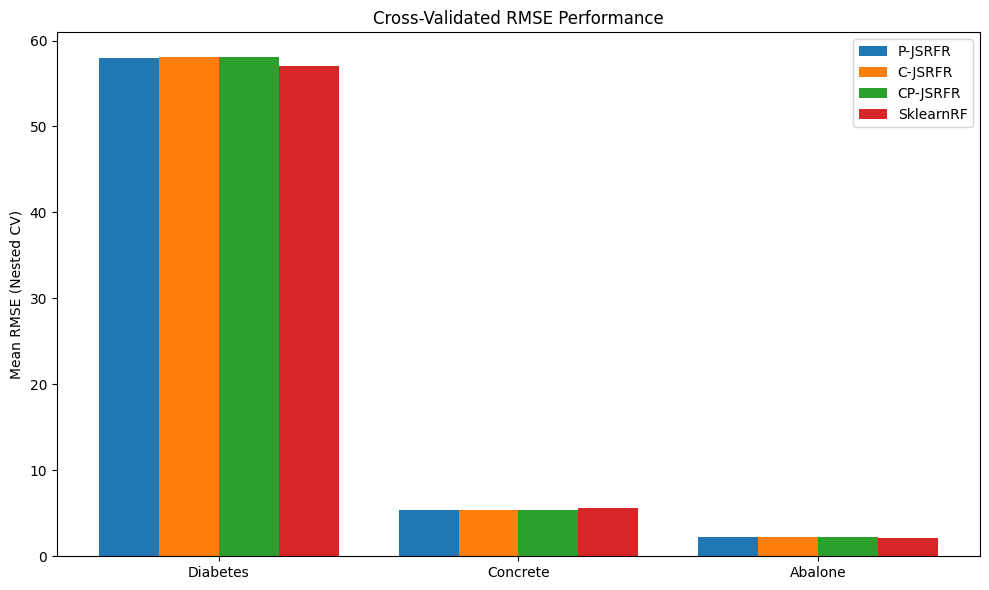

In [ ]:
if __name__=="__main__":
    main()